In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchmetrics.functional import pairwise_cosine_similarity

import pickle
import PIL.Image as Image
import cv2
from skimage.metrics import structural_similarity

## Model declarations 

In [2]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=588, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Misc functions

In [3]:
def weights_init(m):
    try:
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.weight' % m._get_name())
    try:
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)
    except Exception:
        print('warning: failed in weights_init for %s.bias' % m._get_name())

## Data functions

In [4]:
class Dataset_from_Image(Dataset):
    def __init__(self, imgs, labs, transform=None):
        self.imgs = imgs # img paths
        self.labs = labs # labs is ndarray
        self.transform = transform
        del imgs, labs

    def __len__(self):
        return self.labs.shape[0]

    def __getitem__(self, idx):
        lab = self.labs[idx]
        img = Image.open(self.imgs[idx])
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = self.transform(img)
        return img, lab

In [5]:
def lfw_dataset(lfw_path, shape_img):
    images_all = []
    labels_all = []
    folders = os.listdir(lfw_path)
    print(folders)
    for foldidx, fold in enumerate(folders):
        files = os.listdir(os.path.join(lfw_path, fold))
        for f in files:
            if len(f) > 4 and f[-4:] == '.jpg':
                images_all.append(os.path.join(lfw_path, fold, f))
                labels_all.append(foldidx)

    transform = transforms.Compose([transforms.Resize(size=shape_img)])
    dst = Dataset_from_Image(images_all, np.asarray(labels_all, dtype=int), transform=transform)
    return dst

In [6]:
def load_data(dataset, data_path):
    data_params = {}
    if dataset == 'MNIST':
        data_params['shape_img'] = (28, 28)
        data_params['num_classes'] = 10
        data_params['channel'] = 1
        data_params['hidden'] = 588
        data_params['dst'] = datasets.MNIST(data_path, download=False)

    elif dataset == 'cifar100':
        data_params['shape_img'] = (32, 32)
        data_params['num_classes'] = 100
        data_params['channel'] = 3
        data_params['hidden'] = 768
        data_params['dst'] = datasets.CIFAR100(data_path, download=False)

    elif dataset == 'lfw':
        # 32 - 768, 40 - 1200, 50 - 2028
        data_params['shape_img'] = (50, 50)
        data_params['num_classes'] = 5749
        data_params['channel'] = 3
        data_params['hidden'] = 2028
        data_params['lfw_path'] = os.path.join(root_path, '../data/lfw')
        data_params['dst'] = lfw_dataset(data_params['lfw_path'], data_params['shape_img'])

    else:
        exit('unknown dataset')
        
    return data_params
    

In [7]:
def get_metrics(original_image, generated_image, print_metrics=False):
#     original_image = original_image.copy()
#     generated_image = generated_image.copy()
    mse = torch.mean((dummy_data-gt_data)**2).item()
    original_image = original_image.cpu()[0].permute(1, 2, 0).numpy()
    generated_image = generated_image.detach().cpu()[0].permute(1, 2, 0).numpy()
    
    psnr = cv2.PSNR(original_image, generated_image)
    (score, diff) = structural_similarity(original_image, generated_image, full=True, win_size=3)
    if print_metrics:
        print(f"MSE: {mse}, PSNR: {psnr}, SSIM: {score}")
    return mse, psnr, score

In [8]:
def plot_metrics(mse, psnr, ssim):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

    ax1.title.set_text('MSE')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('MSE')
    ax1.plot(mse)

    ax2.title.set_text('PSNR')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('PSNR')
    ax2.plot(psnr)

    ax3.title.set_text('SSIM')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('SSIM')
    ax3.plot(ssim)

## Args

##### Paths

In [9]:
dataset = 'lfw'
root_path = '.'

##### Model params

In [10]:
lr = 1.0
num_dummy = 1
Iteration = 20000
num_exp = 1

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
tt = transforms.Compose([transforms.ToTensor()])
tp = transforms.Compose([transforms.ToPILImage()])

In [13]:
root_path = '.'
data_path = os.path.join(root_path, '../data')
save_path = os.path.join(root_path, 'results/iDLG_%s'%dataset)

In [14]:
if not os.path.exists('results'):
    os.mkdir('results')
if not os.path.exists(save_path):
    os.mkdir(save_path)

#### Choosing the data

In [15]:
data_params = load_data(dataset, data_path)
dst = data_params['dst']
num_classes = data_params['num_classes']
hidden = data_params['hidden']
channels = data_params['channel']

['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abba_Eban', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_al-Attiyah', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullatif_Sener', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adelina_Avila', 'Adel_Al-Jubeir', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego', 'Agnelo_Queiroz', 'Agnes_Br

Lenet

In [16]:
net = LeNet(channel=channels,  
            hideen=hidden,
            num_classes=num_classes)

In [17]:
net

LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=2028, out_features=5749, bias=True)
  )
)

### Training

In [18]:
for idx_net in range(num_exp):
    net.apply(weights_init)

    print('running %d|%d experiment'%(idx_net, num_exp))
    net = net.to(device)
    idx_shuffle = np.random.permutation(len(dst))

    print('%s, Try to generate %d images' % ('IDLG', num_dummy))

    criterion = nn.CrossEntropyLoss().to(device)
    imidx_list = []

    for imidx in range(num_dummy):
        idx = idx_shuffle[imidx]
        imidx_list.append(idx)
        tmp_datum = tt(dst[idx][0]).float().to(device)
        tmp_datum = tmp_datum.view(1, *tmp_datum.size())
        tmp_label = torch.Tensor([dst[idx][1]]).long().to(device)
        tmp_label = tmp_label.view(1, )
        if imidx == 0:
            gt_data = tmp_datum
            gt_label = tmp_label
        else:
            gt_data = torch.cat((gt_data, tmp_datum), dim=0)
            gt_label = torch.cat((gt_label, tmp_label), dim=0)


    # compute original gradient
    out = net(gt_data)
    y = criterion(out, gt_label)
    dy_dx = torch.autograd.grad(y, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn((gt_data.shape[0], num_classes)).to(device).requires_grad_(True)

    optimizer = torch.optim.AdamW([dummy_data, ], lr=0.001, weight_decay=1e-5)#torch.optim.LBFGS([dummy_data, ], lr=lr)
    # predict the ground-truth label
    label_pred = torch.argmin(torch.sum(original_dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)

    history = []
    history_iters = []
    losses = []
    mses = []
    train_iters = []
    psnrs = []
    ssims = []

    print('lr =', lr)
    
    start_time = time.time()
    for iters in range(Iteration):

        def closure():
            optimizer.zero_grad()
            pred = net(dummy_data)
            dummy_loss = criterion(pred, label_pred)

            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            mse = lambda gx, gy: ((gx - gy) ** 2).sum()
            cosine_sim = lambda gx, gy: pairwise_cosine_similarity(gx.view(1, -1), gy.view(1, -1))
            loss = cosine_sim
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += loss(gx, gy)
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)
        current_loss = closure().item()
        train_iters.append(iters)
        losses.append(current_loss)
        
        mse, psnr, ssim = get_metrics(gt_data, dummy_data)
        mses.append(torch.mean((dummy_data-gt_data)**2).item())
#         mses.append(mse)
        psnrs.append(psnr)
        ssims.append(ssim)

        if iters % int(Iteration / 30) == 0:
            print(f"Time taken for step: {time.time() - start_time}")
            current_time = str(time.strftime("[%Y-%m-%d %H:%M:%S]", time.localtime()))
            print(current_time, iters, 'loss = %.8f, mse = %.8f' %(current_loss, mses[-1]))
            get_metrics(gt_data, dummy_data, print_metrics=True)
            history.append([tp(dummy_data[imidx].cpu()) for imidx in range(num_dummy)])
            history_iters.append(iters)

            for imidx in range(num_dummy):
                plt.figure(figsize=(12, 8))
                plt.subplot(3, 10, 1)
                plt.imshow(tp(gt_data[imidx].cpu()))
                for i in range(min(len(history), 29)):
                    plt.subplot(3, 10, i + 2)
                    plt.imshow(history[i][imidx])
                    plt.title('iter=%d' % (history_iters[i]))
                    plt.axis('off')
                plt.savefig('%s/iDLG_on_%s_%05d.png' % (save_path, imidx_list, imidx_list[imidx]))
                plt.close()

#             if current_loss < 0.000001: # converge
#                 break
            start_time = time.time()

    loss_iDLG = losses
    label_iDLG = label_pred.item()
    mse_iDLG = mses



    print('imidx_list:', imidx_list)
    print('gt_label:', gt_label.detach().cpu().data.numpy(), 'lab_iDLG:', label_iDLG)

    print('----------------------\n\n')
    break

running 0|1 experiment
IDLG, Try to generate 1 images
lr = 1.0
Time taken for step: 0.02500009536743164
[2022-11-15 16:25:40] 0 loss = 5.36358643, mse = 1.22502291
MSE: 1.2250229120254517, PSNR: 47.24936166767659, SSIM: 0.0004953800042233583
Time taken for step: 17.576310634613037
[2022-11-15 16:25:58] 666 loss = -3.78257227, mse = 1.23046565
MSE: 1.2304656505584717, PSNR: 47.23010874474903, SSIM: 0.0004523716182305786
Time taken for step: 15.935155153274536
[2022-11-15 16:26:14] 1332 loss = -4.35679579, mse = 1.22949374
MSE: 1.2294937372207642, PSNR: 47.23354017458077, SSIM: 0.0008133842281671614
Time taken for step: 15.077089548110962
[2022-11-15 16:26:29] 1998 loss = -4.52495241, mse = 1.24089420
MSE: 1.2408941984176636, PSNR: 47.19345612404622, SSIM: 0.0008822978372262153
Time taken for step: 16.256970405578613
[2022-11-15 16:26:46] 2664 loss = -4.59826994, mse = 1.25365460
MSE: 1.2536545991897583, PSNR: 47.14902463000016, SSIM: 0.0008807445087395394
Time taken for step: 16.2094435

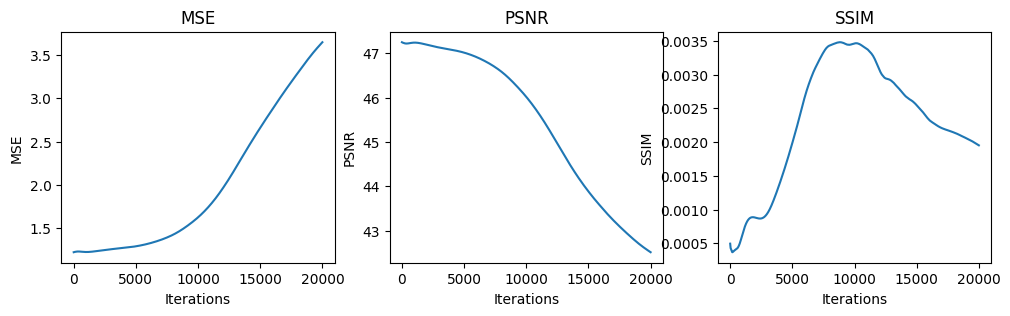

In [26]:
plot_metrics(mses, psnrs, ssims)

## Test codes

In [20]:
from torchmetrics.functional import pairwise_cosine_similarity

In [21]:
optimizer.zero_grad()
pred = net(dummy_data)
dummy_loss = criterion(pred, label_pred)

dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

grad_diff = 0
mse = lambda gx, gy: ((gx - gy) ** 2).sum()
cosine_sim = lambda gx, gy: pairwise_cosine_similarity(gx.view(1, -1), gy.view(1, -1))
loss = cosine_sim
for gx, gy in zip(dummy_dy_dx, original_dy_dx):
    grad_diff += loss(gx, gy)
grad_diff.backward()
# return grad_diff

In [22]:
grad_diff

tensor([[-4.8103]], device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
gx.view(1, -1)

tensor([[5.2000e-17, 5.3215e-13, 1.7491e-18,  ..., 4.1482e-16, 1.2388e-15,
         1.6361e-18]], device='cuda:0', grad_fn=<ViewBackward0>)

In [24]:
pairwise_cosine_similarity(gx.view(1, -1), gy.view(1, -1))

tensor([[0.5980]], device='cuda:0', grad_fn=<MmBackward0>)

In [25]:
pairwise_cosine_similarity(gt_data, dummy_data)

ValueError: Expected argument `x` to be a 2D tensor of shape `[N, d]` but got torch.Size([1, 3, 50, 50])

In [ ]:
gx